# Assignment 2 - MC906: Approximating images with 50 circles using Genetic Algorithm

## Problem modeling:

### Individual: an image with 50 circles

Each circle (gene) has the following parameters:
* left(float): distance to the left normalized between [0.0, 1.0]
* top(float): distance to the top normalized between [0.0, 1.0]
* radius(float): Circle radius
* color(array-like(h,s,v)): Color to be used on render coded as HSV
* alpha(float): Opacity level bound to [0.0, 1.0]

### Population: several sets with 50 circles each


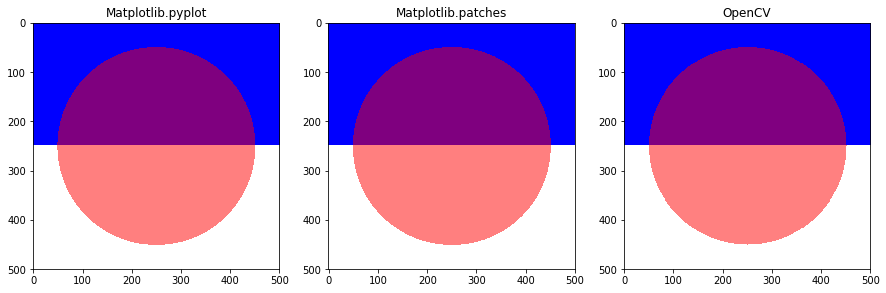

In [2]:
""" Circle plotting comparison """

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pat

FILL_CIRCLE = -1

fig, axs = plt.subplots(ncols=3, figsize=(15,5))

images = np.full(shape=(3, 500,500, 3), dtype=np.uint8, fill_value=255)
images[:, :250, :, :2] = 0
xy = (250, 250)
radius = 200
alpha = 0.5
color = (255, 0, 0)
norm_color = tuple(c/255 if c > 1 else c for c in color)

# Matplotlib.pyplot
image, ax = images[0], axs[0]
ax.add_artist(plt.Circle(xy, radius, facecolor=norm_color, alpha=alpha, antialiased=False))
ax.imshow(image)
ax.set_title('Matplotlib.pyplot')

# Matplotlib.patches
image, ax = images[1], axs[1]
ax.add_patch(pat.Circle(xy, radius, facecolor=norm_color, alpha=alpha, antialiased=False))
ax.imshow(image)
ax.set_title('Matplotlib.patches')

# OpenCV
# https://docs.opencv.org/2.4/modules/core/doc/drawing_functions.html#circle
image, ax = images[2], axs[2]
circle = np.copy(image)
cv2.circle(circle, center=xy, radius=radius, color=color, thickness=FILL_CIRCLE)
cv2.addWeighted(src1=circle, alpha=alpha, src2=image, beta=1-alpha, gamma=0, dst=image)
ax.imshow(image)
ax.set_title('OpenCV')

# fig.savefig('image', dpi=50)
plt.show()

## Useful links:

Aproximação por triangulos: https://github.com/DING-PENG/image-approx

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

from circle import Circle
from image_from_circles import ImageFromCircles
from individual import Individual
from evolve import Evolve
from utils import rms, plot_image, save_image

from skimage.measure import compare_ssim

image_shape = (600, 800, 3)
plot_image(ImageFromCircles([Circle() for i in range(50)]).render(image_shape))

<Figure size 600x600 with 1 Axes>

## Indivíduos


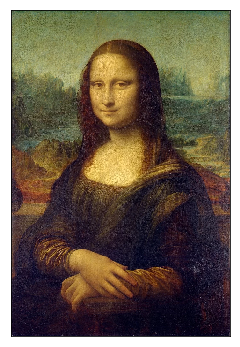

In [2]:
# Read reference image
image = cv2.imread('mona.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)  # Convert color loaded by OpenCV
plot_image(image)

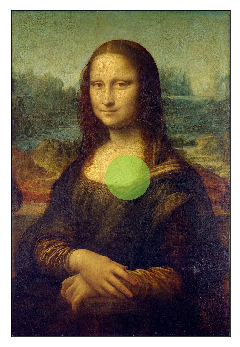

fitness: 43.290055262650995


0.9923371361103333

In [3]:
image_with_circle = np.copy(image)
circle = Circle()
circle.render(image_with_circle)
plot_image(image_with_circle)
print('rms:', rms(image, image_with_circle))
print('ssim:', compare_ssim(image, image_with_circle, multichannel=True))

fitness: -0.14746159319274263
ssim: 0.14746159319274263


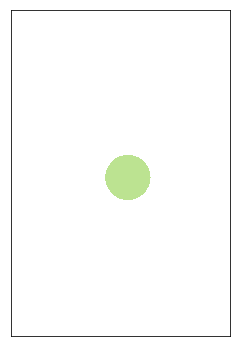

In [4]:
ind = Individual(size=1, circles=[circle])
print('fitness:', ind.update_fitness(image))
print('ssim:', compare_ssim(image, ind.rendered, multichannel=True))

plot_image(ind.rendered)

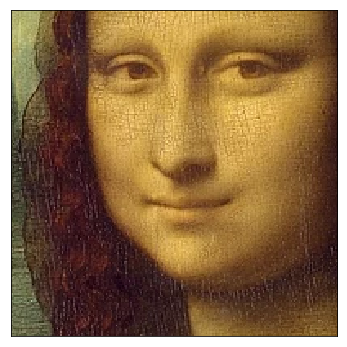

Gen: 0 Fitness: -0.22853737441716757


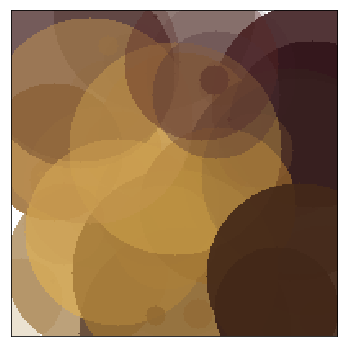

Mutating individuals: 1, 3, 3
Gen: 1 Fitness: -0.22853737441716757
Mutating individuals: 7, 9, 0
Gen: 2 Fitness: -0.22853737441716757
Mutating individuals: 3, 1, 9
Gen: 3 Fitness: -0.23714543803478935
Mutating individuals: 3, 2, 1
Gen: 4 Fitness: -0.23923378686110666
Mutating individuals: 3, 4, 2
Gen: 5 Fitness: -0.23923378686110666
Mutating individuals: 0, 1, 6
Gen: 6 Fitness: -0.23923378686110666
Mutating individuals: 7, 5, 0
Gen: 7 Fitness: -0.24406002740331656
Mutating individuals: 8, 7, 3
Gen: 8 Fitness: -0.23923603648776617
Mutating individuals: 4, 3, 8
Gen: 9 Fitness: -0.23923603648776617
Mutating individuals: 3, 6, 2
Gen: 10 Fitness: -0.23923603648776617


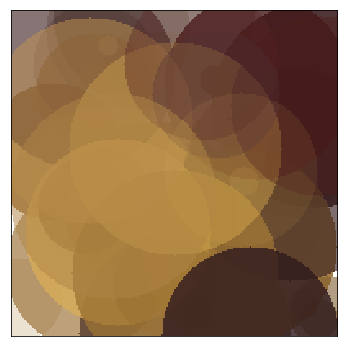

Mutating individuals: 7, 1, 5
Gen: 11 Fitness: -0.23923603648776617
Mutating individuals: 8, 6, 6
Gen: 12 Fitness: -0.23923603648776617
Mutating individuals: 1, 8, 6
Gen: 13 Fitness: -0.23923603648776617
Mutating individuals: 6, 8, 2
Gen: 14 Fitness: -0.23923603648776617
Mutating individuals: 7, 7, 1
Gen: 15 Fitness: -0.23923603648776617
Mutating individuals: 0, 5, 6
Gen: 16 Fitness: -0.23923603648776617
Mutating individuals: 8, 7, 0
Gen: 17 Fitness: -0.23923603648776617
Mutating individuals: 5, 9, 8
Gen: 18 Fitness: -0.23923603648776617
Mutating individuals: 0, 6, 4
Gen: 19 Fitness: -0.23923603648776617
Mutating individuals: 9, 7, 1
Gen: 20 Fitness: -0.23923603648776617


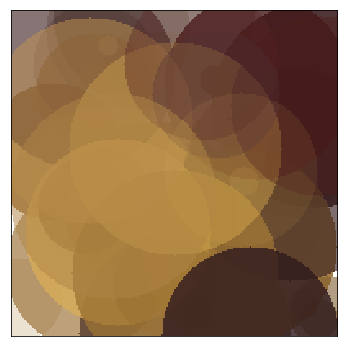

Mutating individuals: 9, 1, 0
Gen: 21 Fitness: -0.23923603648776617
Mutating individuals: 2, 2, 3
Gen: 22 Fitness: -0.23923603648776617
Mutating individuals: 2, 8, 9
Gen: 23 Fitness: -0.23923603648776617
Mutating individuals: 0, 8, 5
Gen: 24 Fitness: -0.23923603648776617
Mutating individuals: 6, 4, 8
Gen: 25 Fitness: -0.23923603648776617
Mutating individuals: 7, 8, 1
Gen: 26 Fitness: -0.23923603648776617
Mutating individuals: 3, 6, 5
Gen: 27 Fitness: -0.23923603648776617
Mutating individuals: 4, 0, 0
Gen: 28 Fitness: -0.23923603648776617
Mutating individuals: 5, 2, 1


In [ ]:
image = cv2.imread('mona.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)  # Convert color loaded by OpenCV
image = image[200:400, 200:400]
plot_image(image)

number_generations = 100

generation = Evolve(image, pop_size=10, crossover_rate=0.3, mutation_rate=0.3, individual_size=50)
generation.evaluate()
generation.plot_image()

for i in range(number_generations):
    generation.crossover()
    generation.mutate()
    generation.evaluate()
    if i % 10 == 9:
        generation.plot_image()